In [45]:
# import some library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import itertools
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [25]:
# read data
df = pd.concat([
    pd.read_csv('../data/feature_selection_positive.csv', index_col=0),
    pd.read_csv('../data/decomp_pos.csv', index_col=0).drop('Subclass', axis=1)
], axis=1)

# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)
features = df.drop('Subclass', axis=1)

# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [46]:
c = pickle.load(open('../model_gs/xgb_fs_deco.sav', 'rb'))

In [62]:
g = xgb.to_graphviz(c)

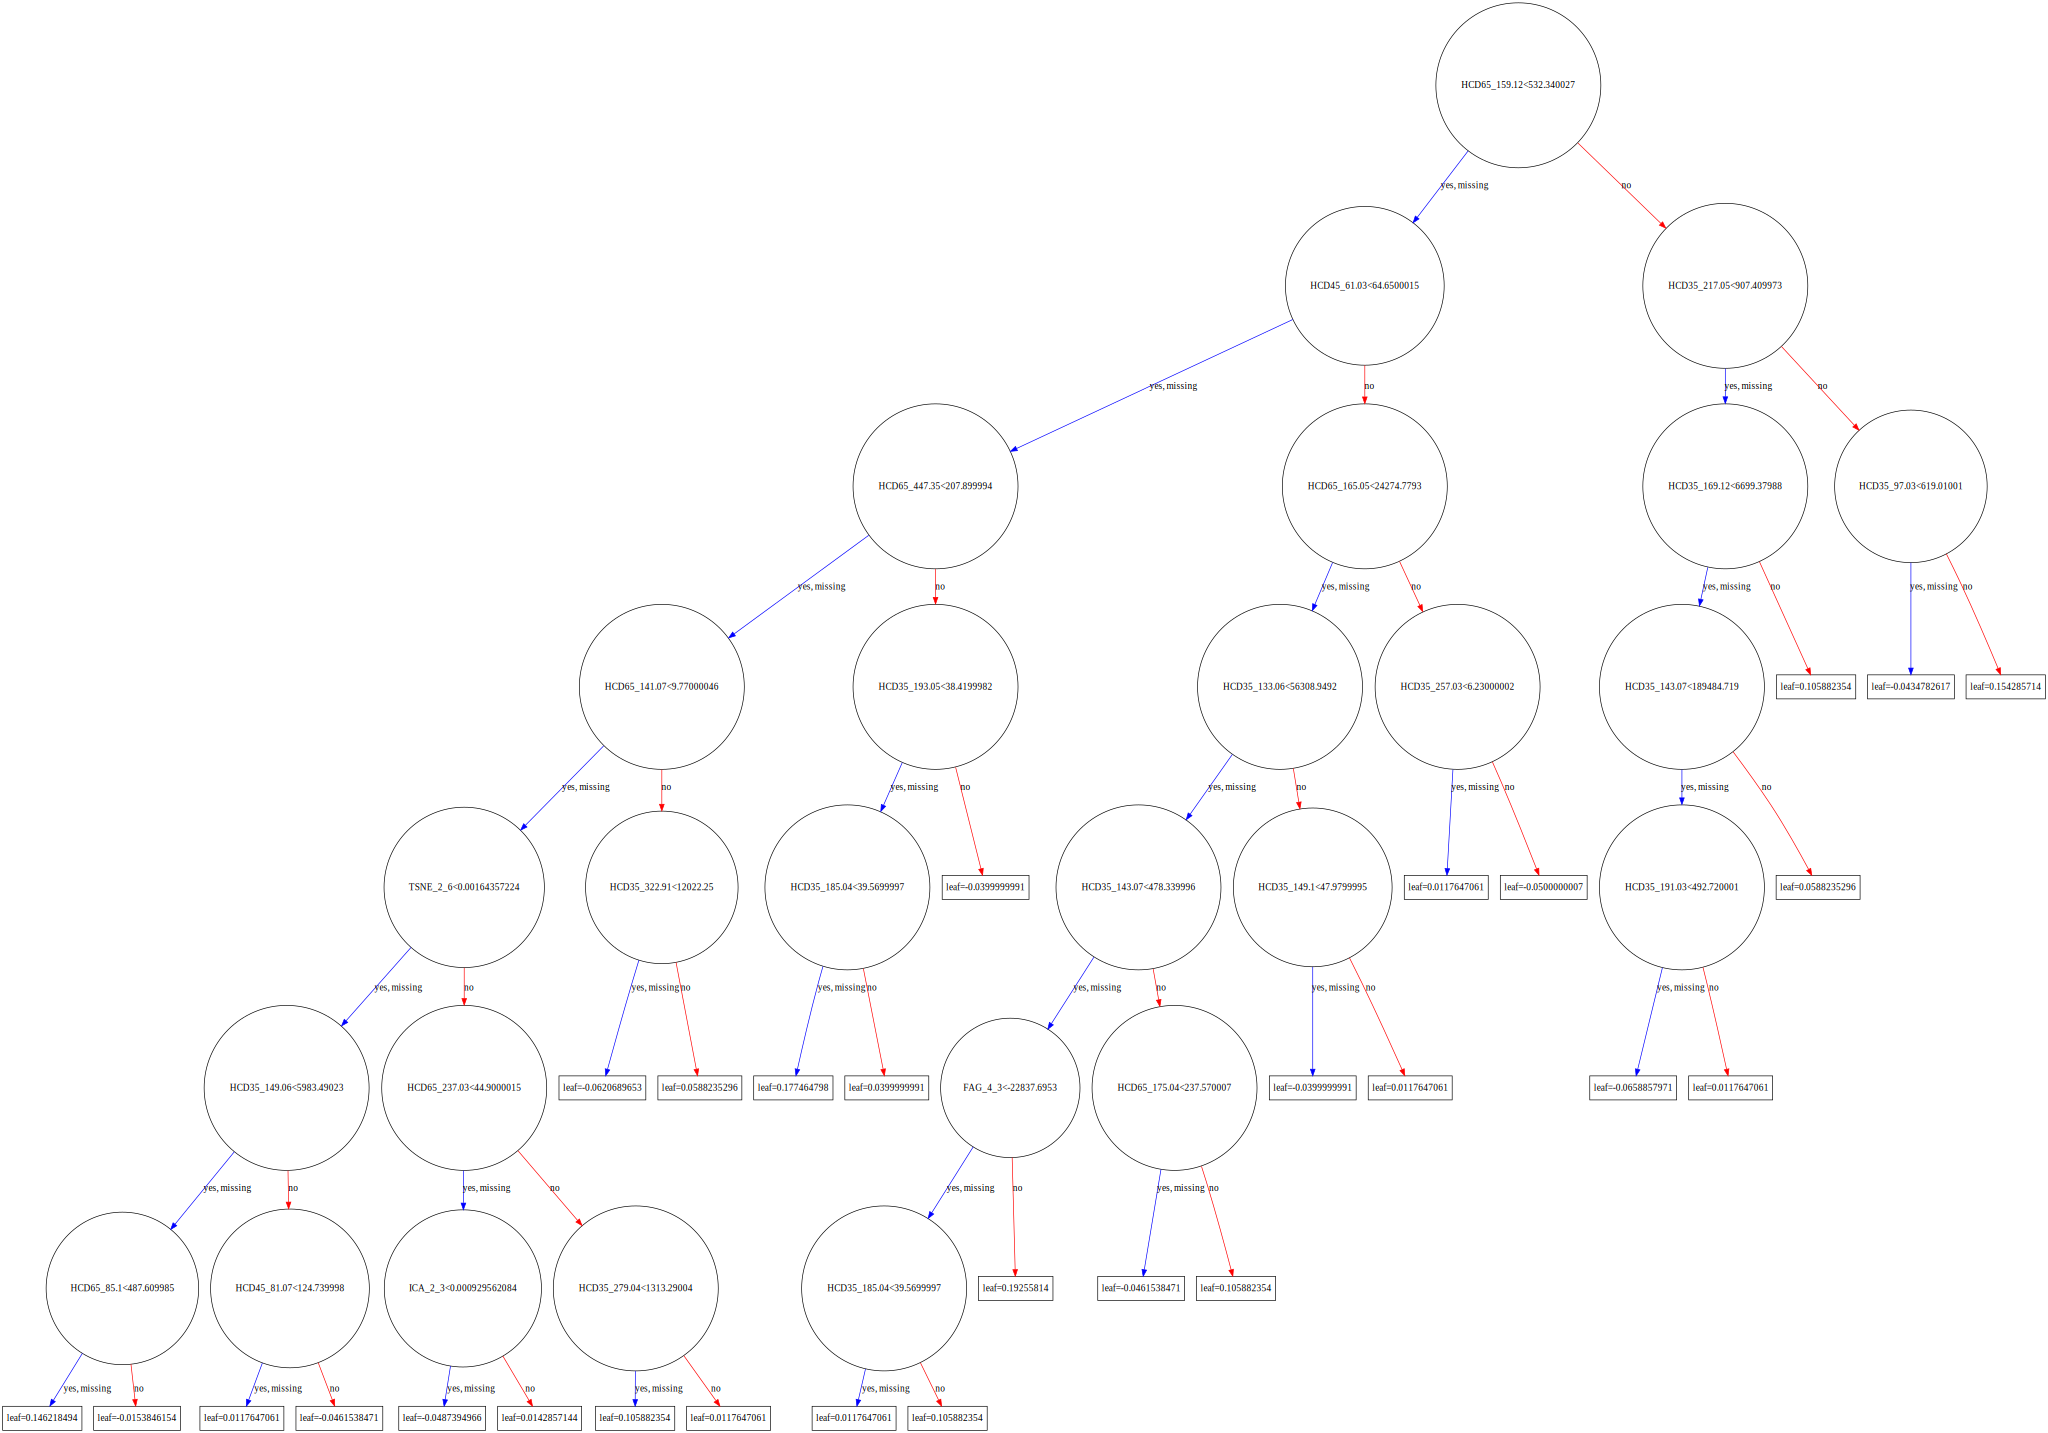

In [67]:
g

In [40]:
xgboost_params = {
    "objective": 'multi:softprob',
    "booster": "gbtree",
    "subsample": 0.4,
    "colsample_bytree": 0.5,
    "max_depth": 7,
    "updater": 'grow_gpu_hist',
    "gpu_id": 0,
    "device": 'gpu',
    'learning_rate': 0.1,
    'n_jobs': -1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'num_class': 4,
    "eval_metric": ['merror', 'mlogloss']
}

# 3.Fit
xgtrain = xgb.DMatrix(X_train, y_train)
xgvalid = xgb.DMatrix(X_test, y_test)

# Now let's fit the model
boost_round = 2000 
eval_dict = dict()
clf = xgb.train(
    xgboost_params, 
    xgtrain, 
    num_boost_round=boost_round, 
    verbose_eval=50,
    maximize=False,  
    evals_result=eval_dict, 
    early_stopping_rounds=100, 
    evals=[(xgvalid, 'valid')]
)

[0]	valid-merror:0.333333	valid-mlogloss:1.30017
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	valid-merror:0.184524	valid-mlogloss:0.490958
[100]	valid-merror:0.160714	valid-mlogloss:0.439306
[150]	valid-merror:0.16369	valid-mlogloss:0.436098
[200]	valid-merror:0.14881	valid-mlogloss:0.433358
[250]	valid-merror:0.151786	valid-mlogloss:0.433007
[300]	valid-merror:0.14881	valid-mlogloss:0.432606
[350]	valid-merror:0.14881	valid-mlogloss:0.436362
[400]	valid-merror:0.145833	valid-mlogloss:0.438823
Stopping. Best iteration:
[304]	valid-merror:0.14881	valid-mlogloss:0.431411



In [41]:
e_list = [float(s) for s in eval_dict['valid']['merror']]
m_list = [float(s) for s in eval_dict['valid']['mlogloss']]

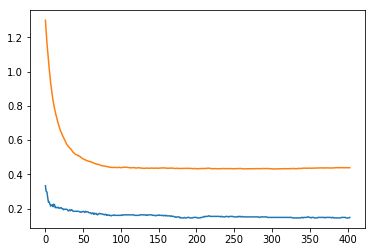

In [43]:
plt.plot(e_list)
plt.plot(m_list)
plt.show()